<a href="https://colab.research.google.com/github/Daishinkan002/Sentiment-Analysis-of-Marathi-Tweets/blob/main/marathi_sentiment_indic_bert_bilstm_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import os
import re
import string
from tqdm import tqdm
import pandas as pd
from multiprocessing import Pool
import numpy as np
import pickle
os.system('pip install -qq transformers')
os.system('pip install -q -U watermark')
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from transformers import AutoModel, AutoTokenizer 
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

# Dataset Loading

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
df_train = pd.read_pickle('/content/gdrive/MyDrive/Major_Project/Marathi-Sentiment/Refined_Dataset/marathi_train.pkl')
df_test = pd.read_pickle('/content/gdrive/MyDrive/Major_Project/Marathi-Sentiment/Refined_Dataset/marathi_test.pkl')
df_valid = pd.read_pickle('/content/gdrive/MyDrive/Major_Project/Marathi-Sentiment/Refined_Dataset/marathi_valid.pkl')

# Data analysis

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Sentiment')

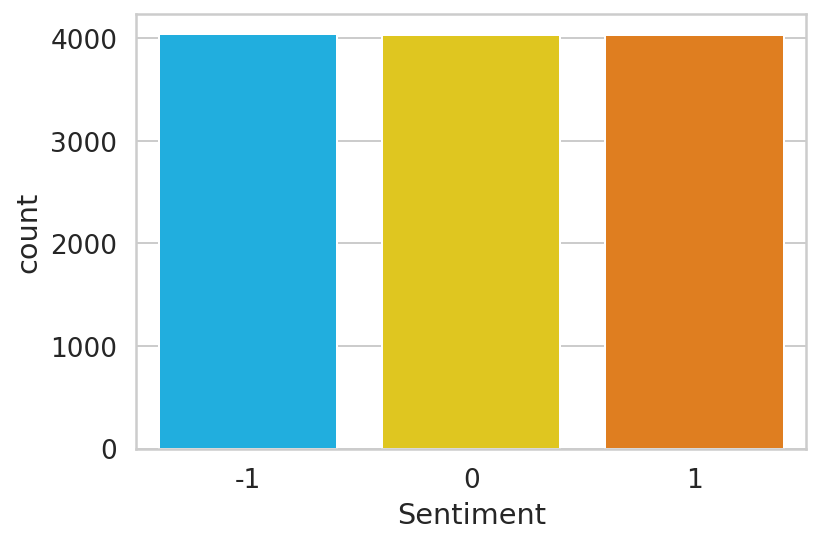

In [ ]:
sns.countplot(df_train.label)
plt.xlabel('Sentiment')

In [ ]:
sns.countplot(df_test.label)
plt.xlabel('Sentiment')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Sentiment')

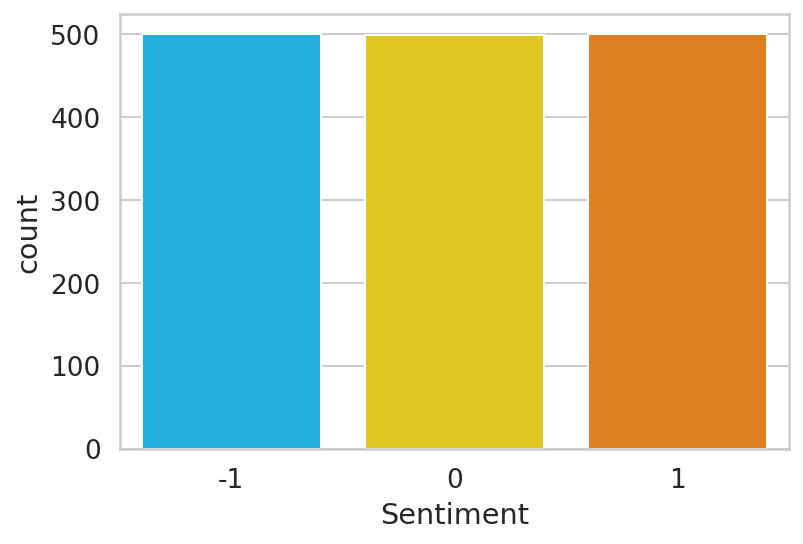

In [ ]:
sns.countplot(df_valid.label)
plt.xlabel('Sentiment')

In [ ]:
pd.set_option("display.max_colwidth", -1)
df_train.head(10)

# Preprocessing with transformers

In [ ]:
!pip install sentencepiece

In [ ]:
# PRE_TRAINED_MODEL_NAME = 'google/muril-base-cased'
PRE_TRAINED_MODEL_NAME = 'ai4bharat/indic-bert'

In [ ]:
indic_bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/507 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129M [00:00<?, ?B/s]

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['sop_classifier.classifier.bias', 'sop_classifier.classifier.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.bias', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/5.38M [00:00<?, ?B/s]

In [ ]:
sample_txt = 'मेरी आणि सामंथा बस स्थानकावर लवकर पोहोचल्या पण दुपारपर्यंत बसची वाट पाहत बसले'

In [ ]:


tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')



In [ ]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

In [ ]:


encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32, # Max no. of tokens 
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids']

In [ ]:
print(len(encoding['token_type_ids'][0]))
encoding['token_type_ids']

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

In [ ]:
token_lens = []
for txt in tqdm(df_train.tuned_tweet):
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

100%|██████████| 12109/12109 [00:04<00:00, 2999.19it/s]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


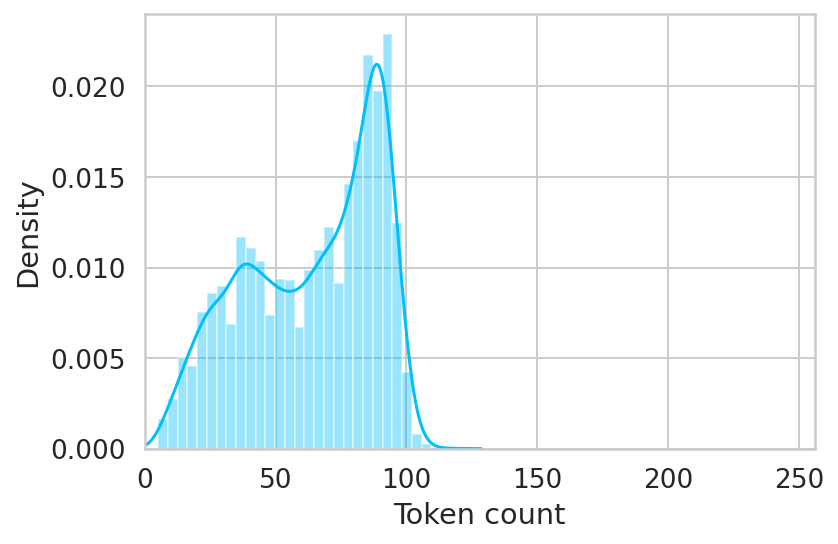

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');
plt.show()

In [ ]:
MAX_LEN = 160

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=True,
      return_attention_mask=True,
      padding= 'max_length',
      # pad_to_max_length = True,
      return_tensors='pt',
    )

    return {
      'tweet_text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'type_ids': encoding['token_type_ids'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train.shape, df_valid.shape, df_test.shape

((12109, 3), (1499, 3), (2250, 3))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    text=df.tuned_tweet.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_valid, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'type_ids', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

# Classification

In [ ]:
print(encoding['attention_mask'] , encoding['token_type_ids'])

In [ ]:
x = indic_bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'],
  token_type_ids=encoding['token_type_ids']
)

In [ ]:
print(x['last_hidden_state'].shape, x['pooler_output'].shape)

In [ ]:
indic_bert_model.config.hidden_size

In [ ]:

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes, base):
    super(SentimentClassifier, self).__init__()
    self.indic = base
    self.drop1 = nn.Dropout(p=0.3)
    self.lstm = nn.LSTM(base.config.hidden_size, 150,bidirectional=True,dropout=0.2)
    self.out1 = nn.Linear(300,64)
    self.relu = nn.ReLU()
    self.drop2 = nn.Dropout(p=0.1) 
    self.out = nn.Linear(64, n_classes)
  
  def forward(self, input_ids, attention_mask, token_type_ids):
    x = self.indic(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    pooled_output = x['pooler_output']
    output = self.drop1(pooled_output)
    output = output.view(len(output), 1, -1)
    output, _ = self.lstm(output)
    output = output.view(len(output), output.shape[-1])
    output =self.relu(self.out1(output))
    output = self.drop2(output)
    return self.out(output)

In [ ]:

class_names = ['-1','0', '1']
model = SentimentClassifier(len(class_names), indic_bert_model)
model = model.to(device)

In [ ]:
data.keys()

In [ ]:

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
token_type_ids = data['type_ids'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length
print(token_type_ids.shape) # batch size x seq_length

In [ ]:
data

In [ ]:
input_ids

In [ ]:
model(input_ids, attention_mask, token_type_ids)

tensor([[-0.0040, -0.1024, -0.1204],
        [ 0.0009, -0.1082, -0.1124],
        [-0.0142, -0.1053, -0.1194],
        [-0.0206, -0.0996, -0.1291],
        [-0.0030, -0.1070, -0.1201],
        [-0.0142, -0.1014, -0.1211],
        [-0.0062, -0.1035, -0.1159],
        [-0.0067, -0.1026, -0.1130],
        [-0.0087, -0.1041, -0.1220],
        [-0.0138, -0.0945, -0.1211],
        [-0.0026, -0.1104, -0.1166],
        [-0.0135, -0.0989, -0.1203],
        [-0.0151, -0.0988, -0.1185],
        [-0.0096, -0.1003, -0.1040],
        [-0.0193, -0.1013, -0.1219],
        [-0.0121, -0.1132, -0.1156]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
F.softmax(model(input_ids, attention_mask, token_type_ids), dim=1)

tensor([[0.3572, 0.3213, 0.3215],
        [0.3540, 0.3254, 0.3206],
        [0.3542, 0.3280, 0.3178],
        [0.3559, 0.3242, 0.3199],
        [0.3551, 0.3273, 0.3175],
        [0.3546, 0.3283, 0.3171],
        [0.3545, 0.3276, 0.3179],
        [0.3563, 0.3260, 0.3177],
        [0.3559, 0.3275, 0.3166],
        [0.3587, 0.3233, 0.3179],
        [0.3551, 0.3267, 0.3183],
        [0.3558, 0.3248, 0.3195],
        [0.3571, 0.3262, 0.3167],
        [0.3569, 0.3266, 0.3165],
        [0.3564, 0.3260, 0.3176],
        [0.3527, 0.3288, 0.3185]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [ ]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in tqdm(data_loader):
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d['type_ids'].to(device)
    targets = d["targets"].to(device)
    targets+=1

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )

    _, preds = torch.max(outputs, dim=1)
  
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d['type_ids'].to(device)
      targets = d["targets"].to(device)
      targets+=1

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids

      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'\n--> Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_valid)
  )

  print(f'--> Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'indic_bert_bilstm_model_state.bin')
    best_accuracy = val_acc


# Results

In [ ]:
for i in range(len(history["train_acc"])):
  history["train_acc"][i]=history["train_acc"][i].cpu() 

In [ ]:
for i in range(len(history["val_acc"])):
  history["val_acc"][i]=history["val_acc"][i].cpu()  

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([.8, 1]);

# Evaluation

In [ ]:
model2 = SentimentClassifier(len(class_names), indic_bert_model)
model2.load_state_dict(torch.load('indic_bert_bilstm_model_state.bin'))
model2.eval()

In [ ]:
model2 = model2.to(device)

In [ ]:
test_acc, _ = eval_model(
  model2,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.7471111111111112

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  tweet_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d['type_ids'].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids = token_type_ids
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      tweet_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweet_texts, predictions, prediction_probs, real_values

In [ ]:

y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
y_pred-=1

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

          -1       0.81      0.82      0.81       750
           0       0.66      0.80      0.73       750
           1       0.80      0.63      0.70       750

    accuracy                           0.75      2250
   macro avg       0.76      0.75      0.75      2250
weighted avg       0.76      0.75      0.75      2250



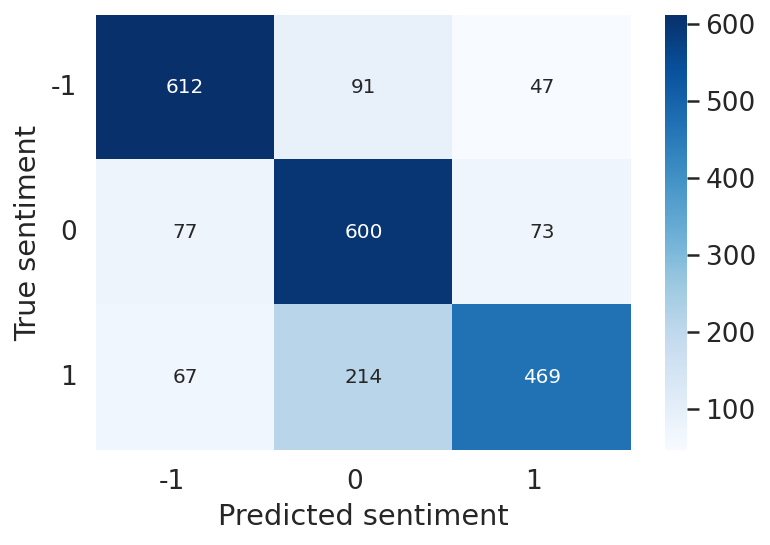

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
y_test[50:60]

In [ ]:
idx = 50

tweet_text = y_tweet_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})



 आमचे मार्गदर्शक, अहमदनगर शहराचे माजी महापौर व माजी नगराध्यक्ष दीप चव्हाण साहेबांना वाढदिवसाच्या मनःपूर्वक शुभेच्छा 




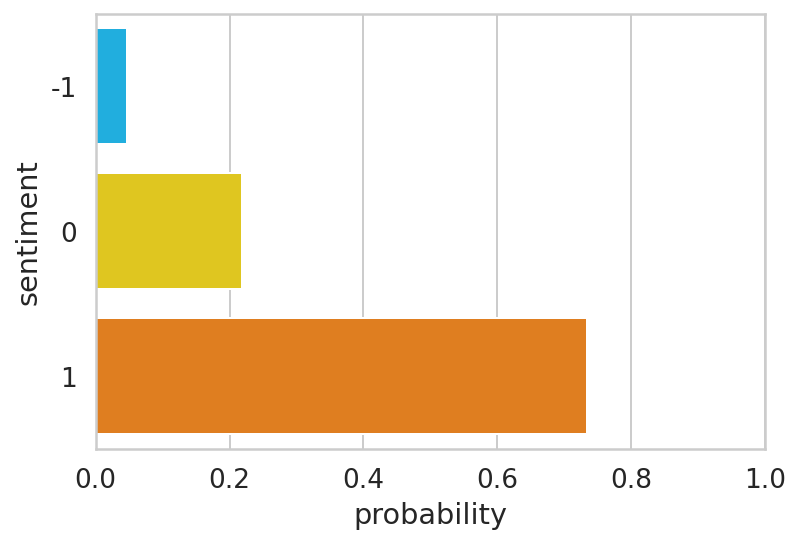

In [ ]:
print('\n\n',tweet_text, '\n\n')

sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
y_test[14], y_tweet_texts[14]

(tensor(-1),
 'भीमा-पाटस साखर कारखान्याच्या कामगारांना २२ महिन्यांचा पगार मिळाला नाही,मग दौंडच्या आमदारांनी तालुक्यासाठी काय केलं याउलट सूतगिरणी अडचणीत आली,म्हणून आपण टेक्स्टाईल पार्क उभारलं ज्यातून ६००० पेक्षा जास्त महिलांना रोजगार मिळाला या भाजपा-शिवसेनावाल्यांनी बारामतीत कोणता उद्योग आणला')

# Custom Prediction

In [ ]:
# strip -> punctuations  -> @ mentions delete -> url delete ->  remove # from #-tokens -> stop words delete (no delete )  -> rare words no delete)
def preprocess(line):

  line = line.strip()
  line = re.sub(r'\S*\.com\S*'," ",line)
  line = re.sub(r'\S*\.in\S*'," ",line)
  line = re.sub(r'\S*\.net\S*'," ",line)
  line = re.sub(r'\S*\.me\S*'," ",line)
  line = re.sub(r'\s+:\s+'," ",line)
  line = re.sub(r'\s+-\s+'," ",line)
  
  
  line = re.sub(r'/https?\/\/(.*\.(in))\//'," ",line)
  line = re.split(r'\s+|[!$%&()*+./;<=>?\^`{|}~\'\"]\s*', line)
  line = [token.strip() for token in line if token != '' and token != ' ' and token != '\n']
  
  if len(line) > 1:
    tokens = []
    for i in range(len(line)):
      if line[i][0] == '#':
        tokens.append(line[i][1:])
      elif line[i][0] == '@' or line[i][0] in string.punctuation :
        continue
      else:
        tokens.append(line[i])
    return tokens


In [ ]:
tweet_text = "नमो सरकारला साधी अडचने पार पाडण्याची बुद्धी नाही आहे. एकदम मूर्खपणाचे लक्षण आहे"
tweet_text = "प्रौढ प्रताप पुरंदर, क्षत्रिय कुलावतंस, सिंहासनाधीश्वर, महाराजाधिराज महाराज श्रीमंत श्री छत्रपती शिवाजी महाराज की जय"
tweet_text = "मनाचे वेधना किती सोसावे सामान्य माणसाने"
tweet_text = "माननीय महोदय संजय विचारे यांच्या अपघाताची बातमी आज कळाली. खूप वाईट वाटले."
tweet_text = "नमो सरकारला साधी अडचने पार पाडण्याची बुद्धी नाही आहे. एकदम मूर्खपणाचे लक्षण आहे"
tweet_text = "गढ आला पण माझा सिंह गेला"
tweet_text = "मैदानात हजारो कंडोम पाकीटं कुणी फेकली?; खुलासा होताच अधिकाऱ्यांनी डोक्यावर हात मारला"
tweet_text = "महाशिवरात्रीच्या सर्वांना हार्दिक हार्दिक शुभेच्छा"
tweet_text= "नमो सरकारला साधी अडचने पार पाडण्याची बुद्धी नाही आहे. एकदम मूर्खपणाचे लक्षण आहे"
tweet_text = "हिंदू धर्मात मुलांना लहानपणापासून आपला धर्मग्रंथ गीता शिकवला जात नाही हे सत्य आहे."
tweet_text = "प्रा. यारकुंडकरांसारख्या थोर वयकतीमत्वाचा परिचय देताना, मला आज प्रचंड अभिमान वाटतोय."
tweet_text = preprocess(tweet_text)
tweet_text = " ".join(tweet_text)

In [ ]:

encoded_tweet = tokenizer.encode_plus(
  tweet_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=True,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)


In [ ]:
input_ids = encoded_tweet['input_ids'].to(device)
attention_mask = encoded_tweet['attention_mask'].to(device)
token_type_ids = encoded_tweet['token_type_ids'].to(device)

output = model(input_ids, attention_mask, token_type_ids)
_, prediction = torch.max(output, dim=1)

print(f'Tweet text: {tweet_text}')
print(f'Sarcasm  : {class_names[prediction]}')

Tweet text: प्रा यारकुंडकरांसारख्या थोर वयकतीमत्वाचा परिचय देताना, मला आज प्रचंड अभिमान वाटतोय
Sarcasm  : 1
